# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import celerite2
from celerite2 import terms
import torch

# Import raw data

In [2]:
#File containing temperature values
raw_T_data = np.loadtxt('/Users/samsonmercier/Desktop/Work/PhD/Research/Second_Generals/Data/bt-4500k/training_data_T.csv', delimiter=',')
#File containing pressure values
raw_P_data = np.loadtxt('/Users/samsonmercier/Desktop/Work/PhD/Research/Second_Generals/Data/bt-4500k/training_data_P.csv', delimiter=',')

#Last 51 columns are the temperature/pressure values, 
#First 5 are the input values (H2 pressure in bar, CO2 pressure in bar, LoD in hours, Obliquity in deg, H2+Co2 pressure)
raw_inputs = raw_T_data[:, :5]
raw_outputs_T = raw_T_data[:, 5:]
raw_outputs_P = raw_P_data[:, 5:]


# Plotting of the T-P profiles

In [ ]:
for raw_input, raw_output_T, raw_output_P in zip(raw_inputs,raw_outputs_T,raw_outputs_P):
    fig, ax = plt.subplots(1, 1, figsize=[8, 6])
    ax.plot(raw_output_T, np.log(raw_output_P/1000), color='blue', linewidth=2)
    ax.invert_yaxis()
    ax.set_xlabel('Temperature (K)')
    ax.set_ylabel(r'log$_{10}$ Pressure (bar)')
    ax.set_title(rf'H$_2$O : {raw_input[0]} bar, CO$_2$ : {raw_input[1]} bar, LoD : {raw_input[2]:.0f} days, Obliquity : {raw_input[3]} deg')
    plt.show()

# Fitting data with a Gaussian Process - trying it out on one T-P profile (Can't be generalized)

/var/folders/zb/dzv8y8kn1dl5qhcybvz_4nv00000gn/T/ipykernel_62695/145973090.py:26: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(variance)
/var/folders/zb/dzv8y8kn1dl5qhcybvz_4nv00000gn/T/ipykernel_62695/145973090.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


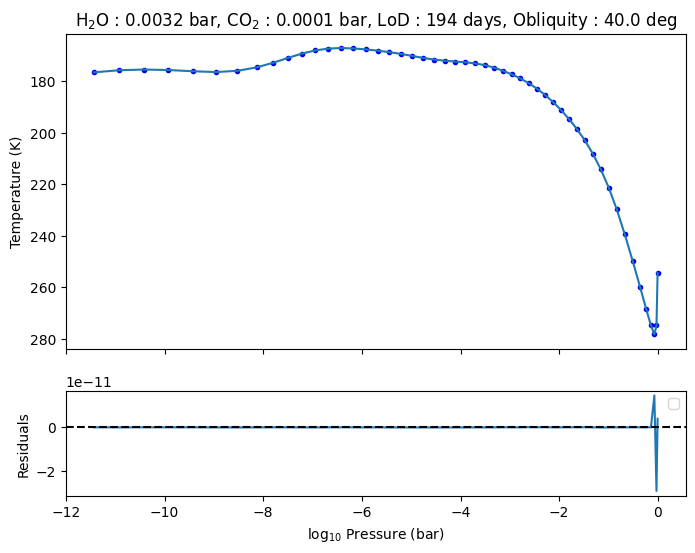

In [3]:
key = 4

#Plot the T-P profile we want to look at
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=[8, 6], gridspec_kw={'height_ratios':[3,1]})
ax1.plot(np.log(raw_outputs_P[4]/1000), raw_outputs_T[4], '.', color='blue', linewidth=2, label='Data')
ax1.invert_yaxis()
ax1.set_ylabel('Temperature (K)')
ax2.set_ylabel('Residuals')
ax2.set_xlabel(r'log$_{10}$ Pressure (bar)')
ax1.set_title(rf'H$_2$O : {raw_inputs[key][0]} bar, CO$_2$ : {raw_inputs[key][1]} bar, LoD : {raw_inputs[key][2]:.0f} days, Obliquity : {raw_inputs[key][3]} deg')

#GP
#Defining a quasi-periodic term
term1 = terms.SHOTerm(sigma=1.0, rho=1.0, tau=10.0)

#Defining a non-periodic term
term2 = terms.SHOTerm(sigma=1.0, rho=5.0, Q=0.25)
kernel = term1 + term2

# Setup the GP
gp = celerite2.GaussianProcess(kernel, mean=0.0)
gp.compute(np.log(raw_outputs_P[4]/1000))

#Plot resulting GP fit
pred_T, variance = gp.predict(raw_outputs_T[4], t=np.log(raw_outputs_P[4]/1000), return_var=True)
sigma = np.sqrt(variance)
ax1.plot(np.log(raw_outputs_P[4]/1000), pred_T, label='initial guess')
ax1.fill_between(np.log(raw_outputs_P[4]/1000), pred_T - sigma, pred_T + sigma, color="C0", alpha=0.2)
ax2.plot(np.log(raw_outputs_P[4]/1000), raw_outputs_T[4]-pred_T)
ax2.axhline(0, color='black', linestyle='--')
plt.legend()
plt.show()

# Fitting the training data with a transformer neural network

## First step : Define a training, validation, and testing set

In [3]:
#Defining partition of data used for 1. training 2. validation and 3. testing
data_partitions = [0.7, 0.1, 0.2]

#Defining the noise seed for the random partitioning of the training data
partition_seed = 4

#Splitting the data 
## Setting noise seec
generator = torch.Generator().manual_seed(partition_seed)
## Retrieving indices of data partitions
train_idx, valid_idx, test_idx = torch.utils.data.random_split(range(raw_outputs_T.shape[0]), data_partitions, generator=generator)
## Generate the data partitions
### Training
train_inputs = raw_inputs[train_idx]
train_outputs_T = raw_outputs_T[train_idx]
train_outputs_P = raw_outputs_P[train_idx]
### Validation
valid_inputs = raw_inputs[valid_idx]
valid_outputs_T = raw_outputs_T[valid_idx]
valid_outputs_P = raw_outputs_P[valid_idx]
### Testing
test_inputs = raw_inputs[test_idx]
test_outputs_T = raw_outputs_T[test_idx]
test_outputs_P = raw_outputs_P[test_idx]

## Second step : defining the transformer NN

In [10]:
# ---------------------
# Defining transformer hyper-parameters
# ---------------------
## Number of attention heads
att_heads = 16
## Number of encoder/decoder layers 
num_layers = 12
## Dimensionality of internal embeddings (i.e. transformer width)
d_model = 64
## Dimension of the feedforward network model (i.e. size of hidden layer)
dim_feedforward = 128
## Number of inputs
src_len = 4
## Number of outputs
tgt_len = 51

# ---------------------
# Defining the model
# ---------------------
## Layers
src_embed = torch.nn.Linear(1, d_model)   # for 4 inputs as a sequence
tgt_embed = torch.nn.Linear(1, d_model)   # for 51 outputs as a sequence
out_proj  = torch.nn.Linear(d_model, 1)   # back to scalar temps

src_pos = torch.nn.Parameter(torch.randn(1, src_len, d_model))
tgt_pos = torch.nn.Parameter(torch.randn(1, tgt_len, d_model))

transformer = torch.nn.Transformer(
    d_model=d_model,
    nhead=att_heads,
    num_encoder_layers=num_layers,
    num_decoder_layers=num_layers,
    dim_feedforward=dim_feedforward,
    batch_first=True
)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(list(src_embed.parameters()) +
                       list(tgt_embed.parameters()) +
                       list(out_proj.parameters()) +
                       [src_pos, tgt_pos] +
                       list(transformer.parameters()), lr=1e-3)

## Third step: running the training

In [11]:
# ---------------------
# Training loop
# ---------------------
for epoch in range(3):
    optimizer.zero_grad()

    # prepare src: (batch, src_len, 1) -> embed -> add pos
    src = torch.as_tensor(test_inputs, dtype=torch.float64).unsqueeze(-1)                   # (N,4,1)
    src = src_embed(src) + src_pos          # (N,4,d_model)

    # prepare tgt input (here just zeros, could also use shifted Y)
    Y_in = torch.as_tensor(test_outputs_T, dtype=torch.float64)
    tgt = Y_in.unsqueeze(-1)                # (N,51,1)
    tgt = tgt_embed(tgt) + tgt_pos          # (N,51,d_model)

    # run through transformer
    h = transformer(src, tgt)               # (N,51,d_model)

    # project to temps
    Y_pred = out_proj(h).squeeze(-1)        # (N,51)

    # loss
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float